In [1]:
%matplotlib inline
from pprint import pprint
from decimal import Decimal
import itertools

import simulate
import harvesting
import market
import plot
import withdrawal
import numpy

In [2]:
series = market.Returns_US_1871()

pmt 137275.662483
long 0.000799231373183 168354.532779 7431948.007191502
steiner 0.0030576172133 149513.993668 2187434.428455081
rolling 0.00261078797788 151842.555104 2522521.5937079983
cape10 0.00154448137855 121018.085082 5350163.410079259
rollingcape10 0.00197274200755 129828.056201 3904461.570121513
inverted 0.00255351917091 125683.773548 3115886.7592955


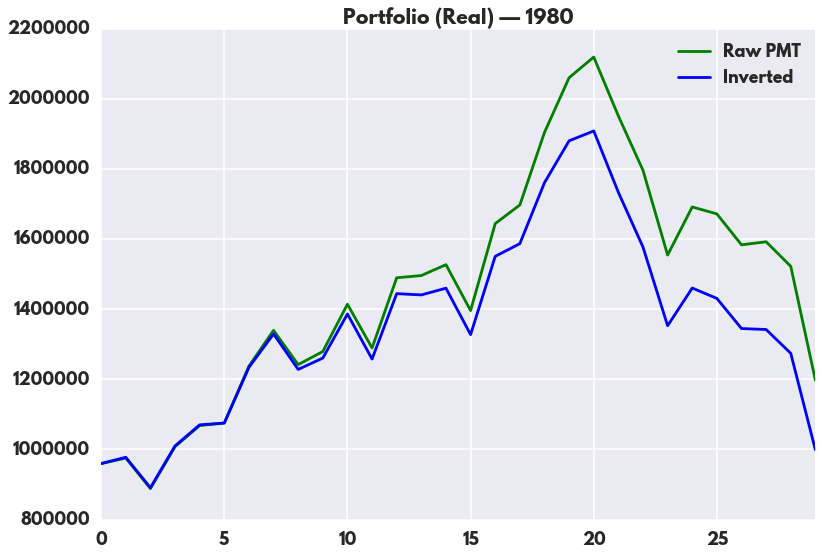

In [24]:
TYPE = 'Portfolio (Real)'
m = {'Withdrawal (Nominal)': lambda x: float(x.withdraw_n),
     'Withdrawal (Real)' : lambda x: float(x.withdraw_r),
     'Portfolio (Nominal)': lambda x: float(x.portfolio_n),
     'Portfolio (Real)': lambda x: float(x.portfolio_r),
}
lens = m[TYPE]
lens.__label__ = TYPE

def fn(x):
    return [lens(_) for _ in x]

year = 1980

plot.seaborn.plt.title('%s — %s' % (lens.__label__, year))

def diff(x):
    (a, b) = itertools.tee(fn(x))
    for n in zip(list(a), [0.1] + list(b)):
        print(round((n[0] - n[1]) / n[1] * 1000) / 10)
        
def check_stat(x):
    (a, b) = itertools.tee(fn(x))
    diffs = [n[0] - n[1] for n in zip(list(a), [0] + list(b))]
    return(numpy.std(diffs[1:]))

w = {
    'longinvest': lambda p, s: withdrawal.LonginvestSmoothing(withdrawal.VPW(p, s, years_left=50)),
    'steiner' : lambda p, s: withdrawal.SteinerSmoothing(withdrawal.VPW(p, s, years_left=50)),
    'rolling' : lambda p, s: withdrawal.RollingAverageSmoothing(withdrawal.VPW(p, s, years_left=50)),
    'raw' : lambda p, s: withdrawal.VPW(p, s, years_left=50),
    'cape10' : lambda p, s: withdrawal.CAPE10Smoothing(year, withdrawal.VPW(p, s, years_left=50)),
    'rollingcape10' : lambda p, s: withdrawal.RollingAverageSmoothing(withdrawal.CAPE10Smoothing(year, withdrawal.VPW(p, s, years_left=50))),
    'inverted' : lambda p, s: withdrawal.TiltCapital(p, s, tilt=Decimal('.3333')),
}

def run_sim(year, key, length=30):
    portfolio = (500000,500000)
    harvest_strategy = harvesting.make_rebalancer(0.5)
    
    return simulate.withdrawals(series.iter_from(year),
                                 withdraw=w[key],
                                 years=length,
                                 portfolio=portfolio,
                                 harvesting=harvest_strategy)


pmt = run_sim(year, 'raw')
ts = plot.seaborn.tsplot([lens(n) for n in pmt], color='green', legend=True, condition='Raw PMT')
#ts.axes.set_ylim(bottom=0)

long = run_sim(year, 'longinvest')
#plot.seaborn.tsplot([lens(n) for n in long], color='purple', legend=True, condition='Longinvest Smoothing')

steiner = run_sim(year, 'steiner')
#plot.seaborn.tsplot([lens(n) for n in steiner], color='orange', legend=True, condition='Steiner Smoothing')

rolling = run_sim(year, 'rolling')
#plot.seaborn.tsplot([lens(n) for n in rolling], color='red', legend=True, condition='Rolling Avg')

cape10 = run_sim(year, 'cape10')
#plot.seaborn.tsplot([lens(n) for n in cape10], color='white', legend=True, condition='CAPE10')

rollingcape10 = run_sim(year, 'rollingcape10')
#plot.seaborn.tsplot([lens(n) for n in rollingcape10], color='yellow', legend=True, condition='RollingCAPE10')

inverted = run_sim(year, 'inverted')
plot.seaborn.tsplot([lens(n) for n in inverted], color='blue', legend=True, condition='Inverted')

def rainy_day(actual, goal):
    return abs(sum([g-a for (g, a) in zip(fn(goal), fn(actual))]))

def make_ratio(actual, goal):
    # a lower standard deviation is better, so we need to take the inverse of it.
    # a lower rainy day fund is better
    # the higher this ratio the better

    # the numbers we generate are tiny, so scale them up to make them
    # easier for a human to eyeball
    SCALING_FACTOR = 1000000000
    return (1/check_stat(actual)) / rainy_day(actual, pmt) * SCALING_FACTOR

print("pmt", check_stat(pmt))
print("long", make_ratio(long, pmt), check_stat(long), rainy_day(long, pmt))
print("steiner", make_ratio(steiner, pmt), check_stat(steiner), rainy_day(steiner, pmt))
print("rolling", make_ratio(rolling, pmt), check_stat(rolling), rainy_day(rolling, pmt))
print("cape10", make_ratio(cape10, pmt), check_stat(cape10), rainy_day(cape10, pmt))
print("rollingcape10", make_ratio(rollingcape10, pmt), check_stat(rollingcape10), rainy_day(rollingcape10, pmt))
print("inverted", make_ratio(inverted, pmt), check_stat(inverted), rainy_day(inverted, pmt))

In [4]:
key = 'rolling'
vals = []
for i in range(1871, 1985):
    pmt = run_sim(i, 'raw')
    actual = run_sim(i, key)
    #ratio = make_ratio(actual, pmt)
    ratio = check_stat(actual)
    #print(i, ratio)
    vals.append(ratio)
vals.remove(max(vals))
print('mean', numpy.mean(vals))
print('median', numpy.median(vals))
print('stdev', numpy.std(vals))

mean 3308.62961853
median 3077.83080689
stdev 956.30792854
